In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [2]:
students = pd.read_csv('students.csv')
students['Name'] = students['Name'].str.lower()

# What's in a Name?

So far, we have asked a broad question about our data: "Do the first names of students tell us anything about the class?"

We have cleaned our data by converting all our names to lowercase. During our exploratory data analysis we discovered that our class contains about 270 names of students in the class and on the waitlist. Most of our first names are between 4 and 8 characters long.

What else can we discover about our class based on their first names? We might consider a single name from our dataset:

In [3]:
students['Name'][5]

'jerry'

From this name we can infer that the student is likely a male. We can also take a guess at the student's age. For example, if we happen to know that Jerry was a very popular baby name in 1990's, we might guess that this student is around twenty years old.

This thinking gives us two new questions to investigate:

1. "Do the first names of students tell us the distribution of sex in the class?"
1. "Do the first names of students tell us the distribution of ages in the class?"

In order to investigate these questions, we will need a dataset that associates names with sex and year. Conveniently, the US Social Security department hosts such a dataset online ([https://www.ssa.gov/oact/babynames/index.html](https://www.ssa.gov/oact/babynames/index.html)). Their dataset records the names given to babies at birth and is thus often referred to as the Baby Names dataset.

We will start by downloading and then loading the dataset into Python. Again, don't worry about understanding the code in this this chapter—focus instead on understanding the overall process.

[zipfile]: https://en.wikipedia.org/wiki/Zip_(file_format)

In [4]:
import urllib.request
import os.path

data_url = "https://www.ssa.gov/oact/babynames/names.zip"
local_filename = "babynames.zip"
if not os.path.exists(local_filename): # if the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())
        
import zipfile
babynames = [] 
with zipfile.ZipFile(local_filename, "r") as zf:
    data_files = [f for f in zf.filelist if f.filename[-3:] == "txt"]
    def extract_year_from_filename(fn):
        return int(fn[3:7])
    for f in data_files:
        year = extract_year_from_filename(f.filename)
        with zf.open(f) as fp:
            df = pd.read_csv(fp, names=["Name", "Sex", "Count"])
            df["Year"] = year
            babynames.append(df)
babynames = pd.concat(babynames)
babynames

,Name,Sex,Count,Year
0,Mary,F,9217,1884
1,Anna,F,3860,1884
2,Emma,F,2587,1884
...,...,...,...,...
2081,Verna,M,5,1883
2082,Winnie,M,5,1883
2083,Winthrop,M,5,1883


It looks like the dataset contains names, the sex given to the baby, the number of babies with that name, and the year of birth for those babies. To be sure, we check the dataset description from the SSN Office ([https://www.ssa.gov/oact/babynames/background.html](https://www.ssa.gov/oact/babynames/background.html)).

> All names are from Social Security card applications for births that occurred in the United States after 1879. Note  that many people born before 1937 never applied for a Social Security card, so their names are not included in our data. For others who did apply, our records may not show the place of birth, and again their names are not included in our data.
> 
> All data are from a 100% sample of our records on Social Security card applications as of March 2017.

We begin by plotting the number of male and female babies born each year:

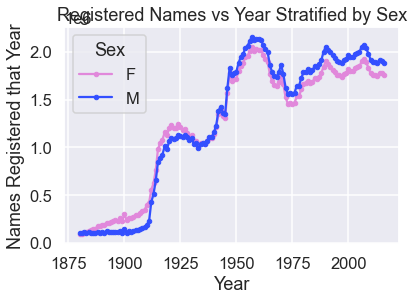

In [5]:
pivot_year_name_count = pd.pivot_table(
    babynames, index='Year', columns='Sex',
    values='Count', aggfunc=np.sum)

pink_blue = ["#E188DB", "#334FFF"]
with sns.color_palette(sns.color_palette(pink_blue)):
    pivot_year_name_count.plot(marker=".")
    plt.title("Registered Names vs Year Stratified by Sex")
    plt.ylabel('Names Registered that Year')

The meteoric rise in babies born in the years leading up to 1920 may seem suspicious. A sentence from the quote above helps explain:

> Note that many people born before 1937 never applied for a Social Security card, so their names are not included in our data. For others who did apply, our records may not show the place of birth, and again their names are not included in our data.

We can also see the [baby boomer period](https://www.wikiwand.com/en/Baby_boomers) quite clearly in the plot above.

## Inferring Sex From Name

Let's use this dataset to estimate the number of females and males in our class. As with our class roster, we begin by lowercasing the names:

In [6]:
babynames['Name'] = babynames['Name'].str.lower()
babynames

,Name,Sex,Count,Year
0,mary,F,9217,1884
1,anna,F,3860,1884
2,emma,F,2587,1884
...,...,...,...,...
2081,verna,M,5,1883
2082,winnie,M,5,1883
2083,winthrop,M,5,1883


Then, we count up how many male and female babies were born in total for each name:

In [7]:
sex_counts = pd.pivot_table(babynames, index='Name', columns='Sex', values='Count',
                            aggfunc='sum', fill_value=0., margins=True)
sex_counts

Sex,F,M,All
Name,,,
aaban,0,96,96
aabha,35,0,35
aabid,0,10,10
...,...,...,...
zyyon,0,6,6
zzyzx,0,5,5
All,170639571,173894326,344533897


To determine whether a name is more popular for male or female babies, we can compute the proportion of times the name was given to a female baby.

In [8]:
prop_female = sex_counts['F'] / sex_counts['All']
sex_counts['prop_female'] = prop_female
sex_counts

Sex,F,M,All,prop_female
Name,,,,
aaban,0,96,96,0.0
aabha,35,0,35,1.0
aabid,0,10,10,0.0
...,...,...,...,...
zyyon,0,6,6,0.0
zzyzx,0,5,5,0.0
All,170639571,173894326,344533897,0.5


We can then define a function that looks up the proportion of female names given a name.

In [9]:
def sex_from_name(name):
    if name in sex_counts.index:
        prop = sex_counts.loc[name, 'prop_female']
        return 'F' if prop > 0.5 else 'M'
    else:
        return 'Name not in dataset'

sex_from_name('sam')

'M'

## Our First Widget

In this book, we include widgets that allow the reader to interact with functions defined in the book. The widget below displays the output of `sex_from_name` on a reader-provided name.

Try typing in the name "josephine" and see how the inferred sex changes as more characters are entered.

In [10]:
interact(sex_from_name, name='sam');

interactive(children=(Text(value='sam', description='name'), Output()), _dom_classes=('widget-interact',))

We mark each name in our class roster with its most likely sex.

In [11]:
students['sex'] = students['Name'].apply(sex_from_name)
students

,Name,Role,sex
0,keeley,Student,F
1,john,Student,M
2,bryan,Student,M
...,...,...,...
276,ernesto,Waitlist Student,M
277,athan,Waitlist Student,M
278,michael,Waitlist Student,M


Now it is easy to estimate how many male and female students we have:

In [12]:
students['sex'].value_counts()

M                      144
F                       92
Name not in dataset     43
Name: sex, dtype: int64

## Inferring Age From Name

We can proceed in a similar way to estimate the age distribution of the class, mapping each name to its average age in the dataset.

In [13]:
def avg_year(group):
    return np.average(group['Year'], weights=group['Count'])

avg_years = (
    babynames
    .groupby('Name')
    .apply(avg_year)
    .rename('avg_year')
    .to_frame()
)
avg_years

,avg_year
Name,
aaban,2012.57
aabha,2013.71
aabid,2009.50
...,...
zyyanna,2010.00
zyyon,2014.00
zzyzx,2010.00


As before, we define a function to lookup the average birth year using a given name. We've included a widget for the reader to try out some names. We suggest trying names that seem older (e.g. "Mary") and names that seem newer (e.g. "Beyonce").

In [14]:
def year_from_name(name):
    return (avg_years.loc[name, 'avg_year']
            if name in avg_years.index
            else None)

# Generate input box for you to try some names out:
interact(year_from_name, name='fernando');

interactive(children=(Text(value='fernando', description='name'), Output()), _dom_classes=('widget-interact',)…

Now, we can mark each name with its inferred birth year.

In [15]:
students['year'] = students['Name'].apply(year_from_name)
students

,Name,Role,sex,year
0,keeley,Student,F,1998.15
1,john,Student,M,1951.08
2,bryan,Student,M,1983.57
...,...,...,...,...
276,ernesto,Waitlist Student,M,1981.44
277,athan,Waitlist Student,M,2004.40
278,michael,Waitlist Student,M,1971.18


Then, it is easy to plot the distribution of years:

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


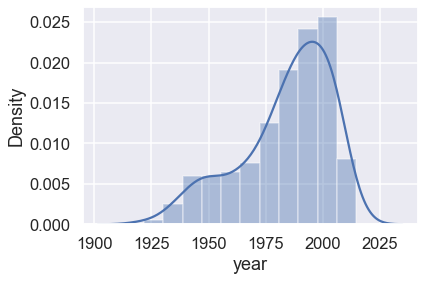

In [16]:
sns.distplot(students['year'].dropna());

To compute the average year:

In [17]:
students['year'].mean()

1983.846741800525

Our class has an average age of 35 years old—nearly twice our expected age in a course for college undergraduates. Why might our estimate be so far off?

As data scientists, we often run into results that don't agree with our expectations. Our constant challenge is to determine whether surprising results are caused by an error in our procedure or by an actual, real-world phenomenon. Since there are no simple recipes to guarantee accurate conclusions, data scientists must equip themselves with guidelines and principles to reduce the likelihood of false discovery.

In this particular case, the most likely explanation for our unexpected result is that most common names have been used for many years. For example, the name John was quite popular throughout the history recorded in our data. We can confirm this by plotting the number of babies given the name "John" each year:

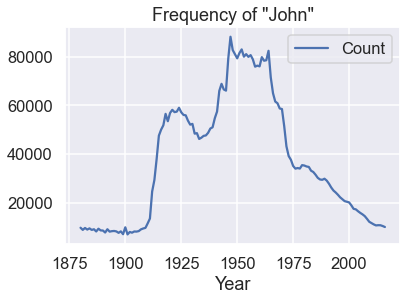

In [18]:
names = babynames.set_index('Name').sort_values('Year')
john = names.loc['john']
john[john['Sex'] == 'M'].plot('Year', 'Count')
plt.title('Frequency of "John"');

It appears that the average birth year does not provide an accurate estimate for a given person's age in general. In a few cases, however, a person's first name is quite revealing!

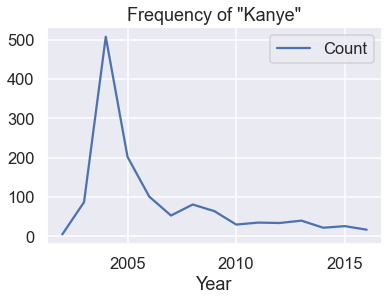

In [19]:
names = babynames.set_index('Name').sort_values('Year')
kanye = names.loc['kanye']
kanye[kanye['Sex'] == 'M'].plot('Year', 'Count')
plt.title('Frequency of "Kanye"');

## Summary

In this chapter, we walk through a complete iteration of the data science lifecycle: question formulation, data manipulation, exploratory data analysis, and prediction. We expand upon each of these steps in the following chapters.
